# Введение

Оператор связи **«ТелеДом»** хочет снизить отток клиентов. Чтобы предлагать пользователям промокоды и специальные условия до того, как они решат уйти, компании нужна модель, которая предскажет вероятность расторжения договора.  

Для этого в распоряжении есть данные о клиентах, их тарифах и дополнительных услугах. Задача — обучить модель машинного обучения, которая поможет заранее определять абонентов, склонных к уходу.  

В рамках проекта нужно:  
- Подготовить и изучить данные;  
- Выбрать и обучить подходящую модель;  
- Оценить точность предсказаний;  
- Предложить решения по снижению оттока.  

Эта модель поможет **«ТелеДому»** вовремя реагировать на риск ухода клиентов и предлагать им выгодные условия для продолжения использования услуг.

## 1. Загрузка данных

In [55]:
import os
import pandas as pd
import numpy as np
import sqlite3
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from lightgbm import LGBMClassifier
import time

In [56]:
# Путь к базе данных
path = os.path.expanduser('~/final/')
path_to_db = os.path.join(path, 'ds-plus-final.db')

In [57]:
# Создаем соединение SQLite3
conn = sqlite3.connect(path_to_db)

In [58]:
# Получаем список таблиц
tables_list = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(list(tables_list['name']))

['data_arc', 'data_bulk', 'data_bulk_time', 'data_wire_time', 'contract', 'personal', 'phone', 'internet', 'data_gas', 'data_temp', 'data_wire']


In [59]:
# Функция для загрузки таблиц
def load_tables(conn, table_names):
    for table_name in table_names:
        query = f"SELECT * FROM {table_name};"
        df = pd.read_sql(query, conn)  # Используем соединение SQLite3
        globals()[f"{table_name}_df"] = df  # Создаем глобальную переменную

In [60]:
# Загружаем таблицы
table_names = ['contract', 'personal', 'phone', 'internet']
load_tables(conn, table_names)

# Закрываем соединение
conn.close()

In [61]:
contract_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.8,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.2,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.6,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.4,520.8


In [62]:
personal_df

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [63]:
internet_df

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [64]:
phone_df

,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


# Описание данных

Данные хранятся в **SQLite** — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

- **contract** — информация о договорах;
- **personal** — персональные данные клиентов;
- **internet** — информация об интернет-услугах;
- **phone** — информация об услугах телефонии.

---

## Таблица `contract`
| Поле               | Описание                                      |
|--------------------|----------------------------------------------|
| `customerID`      | ID абонента                                  |
| `BeginDate`       | Дата начала действия договора               |
| `EndDate`         | Дата окончания действия договора            |
| `Type`            | Тип оплаты: раз в год-два или ежемесячно    |
| `PaperlessBilling`| Электронный расчётный лист                  |
| `PaymentMethod`   | Тип платежа                                 |
| `MonthlyCharges`  | Расходы за месяц                           |
| `TotalCharges`    | Общие расходы абонента                     |

---

## Таблица `personal`
| Поле            | Описание                              |
|----------------|--------------------------------------|
| `customerID`  | ID пользователя                      |
| `gender`      | Пол                                  |
| `SeniorCitizen` | Является ли абонент пенсионером   |
| `Partner`     | Есть ли у абонента супруг(а)       |
| `Dependents`  | Есть ли у абонента дети            |

---

## Таблица `internet`
| Поле              | Описание                                      |
|------------------|----------------------------------------------|
| `customerID`    | ID пользователя                              |
| `InternetService` | Тип подключения                           |
| `OnlineSecurity` | Блокировка опасных сайтов                 |
| `OnlineBackup`   | Облачное хранилище файлов                 |
| `DeviceProtection` | Антивирус                               |
| `TechSupport`    | Выделенная линия технической поддержки    |
| `StreamingTV`    | Стриминговое телевидение                  |
| `StreamingMovies` | Каталог фильмов                         |

---

## Таблица `phone`
| Поле             | Описание                                      |
|-----------------|----------------------------------------------|
| `customerID`   | ID пользователя                              |
| `MultipleLines` | Подключение телефона к нескольким линиям   |

---

📅 **Информация о договорах актуальна на 1 февраля 2020.**


## 2. Исследовательский анализ  и предобработка данных

In [65]:
contract_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


In [66]:
contract_df.describe()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,1585,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,20.05,
freq,1,366,5942,3875,4171,2365,61,11


In [67]:
print('Типы оплаты: ', ', '.join(contract_df['Type'].unique()))
print('Наличие электронного расчётного листа: ', ', '.join(contract_df['PaperlessBilling'].unique()))
print('Тип платежа: ', ', '.join(contract_df['PaymentMethod'].unique()))

Типы оплаты:  Month-to-month, One year, Two year
Наличие электронного расчётного листа:  Yes, No
Тип платежа:  Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)


In [68]:
personal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


In [69]:
personal_df.describe()

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,7590-VHVEG,Male,0,No,No
freq,1,3555,5901,3641,4933


In [70]:
print('Пол: ', ', '.join(personal_df['gender'].unique()))
print('Является ли абонент пенсионером: ', ', '.join(personal_df['SeniorCitizen'].unique()))
print('Есть ли у абонента супруг(а): ', ', '.join(personal_df['Partner'].unique()))
print('Есть ли у абонента дети: ', ', '.join(personal_df['Dependents'].unique()))

Пол:  Female, Male
Является ли абонент пенсионером:  0, 1
Есть ли у абонента супруг(а):  Yes, No
Есть ли у абонента дети:  No, Yes


In [71]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [72]:
internet_df.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [73]:
print('Тип подключения: ', ', '.join(internet_df['InternetService'].unique()))
print('Блокировка опасных сайтов: ', ', '.join(internet_df['OnlineSecurity'].unique()))
print('Облачное хранилище сайтов: ', ', '.join(internet_df['OnlineBackup'].unique()))
print('Антивирус: ', ', '.join(internet_df['DeviceProtection'].unique()))
print('Выделенная линия технической поддержки: ', ', '.join(internet_df['TechSupport'].unique()))
print('Стриминговое телевидение: ', ', '.join(internet_df['StreamingTV'].unique()))
print('Каталог фильмов: ', ', '.join(internet_df['StreamingMovies'].unique()))

Тип подключения:  DSL, Fiber optic
Блокировка опасных сайтов:  No, Yes
Облачное хранилище сайтов:  Yes, No
Антивирус:  No, Yes
Выделенная линия технической поддержки:  No, Yes
Стриминговое телевидение:  No, Yes
Каталог фильмов:  No, Yes


In [74]:
phone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [75]:
print('Количество уникальных абонентов: ', phone_df['CustomerId'].nunique())
print('Подключение телефона к нескольким линиям: ', ', '.join(phone_df['MultipleLines'].unique()))

Количество уникальных абонентов:  6361
Подключение телефона к нескольким линиям:  No, Yes


### Вывод
В таблицах отсутствуют пропуски и дубликаты. Необходимо преобразовать все даты (`BeginDate`, `EndDate`) в формат `datetime64`, числовые значения (`MonthlyCharges`, `TotalCharges`) в `float` или `int`, а бинарные признаки (`Partner`, `Dependents`, `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`, `SeniorCitizen`, `PaperlessBilling`) в `bool`, заменив `Yes` на `True`, а `No` на `False`.

In [76]:
merged_df = contract_df.merge(
    personal_df, on='customerID', how='left').merge(
    internet_df, on='customerID', how='left').merge(
    phone_df, left_on='customerID', right_on='CustomerId', how='left')

merged_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,CustomerId,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,5575-GNVDE,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,3668-QPYBK,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,9237-HQITU,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.8,2035.2,Male,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,6840-RESVB,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.2,7430.4,Female,0,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,2234-XADUH,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.6,325.6,Female,0,...,Yes,DSL,Yes,No,No,No,No,No,NaN,NaN
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.4,520.8,Male,1,...,No,Fiber optic,No,No,No,No,No,No,8361-LTMKD,Yes


In [77]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
 8   gender            7043 non-null   object
 9   SeniorCitizen     7043 non-null   object
 10  Partner           7043 non-null   object
 11  Dependents        7043 non-null   object
 12  InternetService   5517 non-null   object
 13  OnlineSecurity    5517 non-null   object
 14  OnlineBackup      5517 non-null   object
 15  DeviceProtection  5517 non-null   object
 16  TechSupport       5517 non-null   object
 17  StreamingTV   

In [78]:
merged_df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
CustomerId           682
MultipleLines        682
dtype: int64

In [79]:
merged_df.drop(columns=['customerID','CustomerId'], axis=1, inplace=True)

In [80]:
merged_df.fillna({'InternetService' : False, 
                  'OnlineSecurity' : False, 
                  'OnlineBackup' : False,
                  'DeviceProtection' : False, 
                  'TechSupport' : False, 
                  'StreamingTV' : False, 
                  'StreamingMovies' : False,
                  'MultipleLines' : False}, inplace=True)

In [81]:
merged_df.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [82]:
merged_df

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,False
1,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,False
4,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2018-02-01,No,One year,Yes,Mailed check,84.8,2035.2,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2014-02-01,No,One year,Yes,Credit card (automatic),103.2,7430.4,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,2019-03-01,No,Month-to-month,Yes,Electronic check,29.6,325.6,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,False
7041,2019-07-01,No,Month-to-month,Yes,Mailed check,74.4,520.8,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [83]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   BeginDate         7043 non-null   object
 1   EndDate           7043 non-null   object
 2   Type              7043 non-null   object
 3   PaperlessBilling  7043 non-null   object
 4   PaymentMethod     7043 non-null   object
 5   MonthlyCharges    7043 non-null   object
 6   TotalCharges      7043 non-null   object
 7   gender            7043 non-null   object
 8   SeniorCitizen     7043 non-null   object
 9   Partner           7043 non-null   object
 10  Dependents        7043 non-null   object
 11  InternetService   7043 non-null   object
 12  OnlineSecurity    7043 non-null   object
 13  OnlineBackup      7043 non-null   object
 14  DeviceProtection  7043 non-null   object
 15  TechSupport       7043 non-null   object
 16  StreamingTV       7043 non-null   object
 17  StreamingMovie

In [84]:
merged_df['EndDate'] = merged_df['EndDate'].replace({'No' : '2020-02-01'}) 
merged_df

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,False
1,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.3,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,False
4,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.7,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.8,2035.2,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.2,7430.4,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.6,325.6,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,False
7041,2019-07-01,2020-02-01,Month-to-month,Yes,Mailed check,74.4,520.8,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [85]:
df_new = merged_df.copy()
pd.set_option('future.no_silent_downcasting', True)
df_new = df_new.replace({'No': False, 'Yes': True, '0': False, '1': True})
df_new['InternetService'] = df_new['InternetService'].replace(False, 'No')
df_new

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,29.85,31.04,Female,False,True,False,DSL,False,True,False,False,False,False,False
1,2017-04-01,2020-02-01,One year,False,Mailed check,56.95,2071.84,Male,False,False,False,DSL,True,False,True,False,False,False,False
2,2019-10-01,2020-02-01,Month-to-month,True,Mailed check,53.85,226.17,Male,False,False,False,DSL,True,True,False,False,False,False,False
3,2016-05-01,2020-02-01,One year,False,Bank transfer (automatic),42.3,1960.6,Male,False,False,False,DSL,True,False,True,True,False,False,False
4,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,70.7,353.5,Female,False,False,False,Fiber optic,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2018-02-01,2020-02-01,One year,True,Mailed check,84.8,2035.2,Male,False,True,True,DSL,True,False,True,True,True,True,True
7039,2014-02-01,2020-02-01,One year,True,Credit card (automatic),103.2,7430.4,Female,False,True,True,Fiber optic,False,True,True,False,True,True,True
7040,2019-03-01,2020-02-01,Month-to-month,True,Electronic check,29.6,325.6,Female,False,True,True,DSL,True,False,False,False,False,False,False
7041,2019-07-01,2020-02-01,Month-to-month,True,Mailed check,74.4,520.8,Male,True,True,False,Fiber optic,False,False,False,False,False,False,True


In [86]:
df_new[['BeginDate', 'EndDate']] = df_new[['BeginDate', 'EndDate']].apply(pd.to_datetime, format = '%Y-%m-%d')

In [87]:
df_new['MonthlyCharges'] = df_new['MonthlyCharges'].astype('float')

In [88]:
df_new['TotalCharges'] = df_new['TotalCharges'].replace(" ", np.nan).astype('float')

In [89]:
df_new['active_status'] = df_new['EndDate'].apply(lambda x: True if x == pd.to_datetime('2020-02-01') else False)
df_new.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,active_status
0,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,29.85,31.04,Female,False,True,False,DSL,False,True,False,False,False,False,False,True
1,2017-04-01,2020-02-01,One year,False,Mailed check,56.95,2071.84,Male,False,False,False,DSL,True,False,True,False,False,False,False,True
2,2019-10-01,2020-02-01,Month-to-month,True,Mailed check,53.85,226.17,Male,False,False,False,DSL,True,True,False,False,False,False,False,True
3,2016-05-01,2020-02-01,One year,False,Bank transfer (automatic),42.30,1960.60,Male,False,False,False,DSL,True,False,True,True,False,False,False,True
4,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,70.70,353.50,Female,False,False,False,Fiber optic,False,False,False,False,False,False,False,True


In [90]:
df_new['active_period'] = (df_new['EndDate'] - df_new['BeginDate']).dt.days
df_new.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,active_status,active_period
0,2020-01-01,2020-02-01,Month-to-month,True,Electronic check,29.85,31.04,Female,False,True,...,DSL,False,True,False,False,False,False,False,True,31
1,2017-04-01,2020-02-01,One year,False,Mailed check,56.95,2071.84,Male,False,False,...,DSL,True,False,True,False,False,False,False,True,1036
2,2019-10-01,2020-02-01,Month-to-month,True,Mailed check,53.85,226.17,Male,False,False,...,DSL,True,True,False,False,False,False,False,True,123
3,2016-05-01,2020-02-01,One year,False,Bank transfer (automatic),42.30,1960.60,Male,False,False,...,DSL,True,False,True,True,False,False,False,True,1371
4,2019-09-01,2020-02-01,Month-to-month,True,Electronic check,70.70,353.50,Female,False,False,...,Fiber optic,False,False,False,False,False,False,False,True,153


In [91]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   object        
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtection  7043 n

In [92]:
df_new.drop(columns=['BeginDate', 'EndDate'], axis=1, inplace=True)
df_new

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,active_status,active_period
0,Month-to-month,True,Electronic check,29.85,31.04,Female,False,True,False,DSL,False,True,False,False,False,False,False,True,31
1,One year,False,Mailed check,56.95,2071.84,Male,False,False,False,DSL,True,False,True,False,False,False,False,True,1036
2,Month-to-month,True,Mailed check,53.85,226.17,Male,False,False,False,DSL,True,True,False,False,False,False,False,True,123
3,One year,False,Bank transfer (automatic),42.30,1960.60,Male,False,False,False,DSL,True,False,True,True,False,False,False,True,1371
4,Month-to-month,True,Electronic check,70.70,353.50,Female,False,False,False,Fiber optic,False,False,False,False,False,False,False,True,153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,One year,True,Mailed check,84.80,2035.20,Male,False,True,True,DSL,True,False,True,True,True,True,True,True,730
7039,One year,True,Credit card (automatic),103.20,7430.40,Female,False,True,True,Fiber optic,False,True,True,False,True,True,True,True,2191
7040,Month-to-month,True,Electronic check,29.60,325.60,Female,False,True,True,DSL,True,False,False,False,False,False,False,True,337
7041,Month-to-month,True,Mailed check,74.40,520.80,Male,True,True,False,Fiber optic,False,False,False,False,False,False,True,True,215


In [93]:
df_new.rename(columns={'Type' : 'type', 
                       'PaperlessBilling' : 'paperless_billing', 
                       'PaymentMethod' : 'payment_method', 
                       'MonthlyCharges' : 'monthly_charges',
                       'TotalCharges' : 'total_charges', 
                       'SeniorCitizen' : 'senior_citizen', 
                       'Partner' : 'partner', 
                       'Dependents' : 'dependents',
                       'InternetService' : 'internet_service', 
                       'OnlineSecurity' : 'online_security', 
                       'OnlineBackup' : 'online_backup', 
                       'DeviceProtection' : 'device_protection', 
                       'TechSupport' : 'tech_support', 
                       'StreamingTV' : 'streaming_tv', 
                       'StreamingMovies' : 'streaming_movies', 
                       'MultipleLines' : 'multiple_lines'}, inplace=True)
df_new.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,active_status,active_period
0,Month-to-month,True,Electronic check,29.85,31.04,Female,False,True,False,DSL,False,True,False,False,False,False,False,True,31
1,One year,False,Mailed check,56.95,2071.84,Male,False,False,False,DSL,True,False,True,False,False,False,False,True,1036
2,Month-to-month,True,Mailed check,53.85,226.17,Male,False,False,False,DSL,True,True,False,False,False,False,False,True,123
3,One year,False,Bank transfer (automatic),42.30,1960.60,Male,False,False,False,DSL,True,False,True,True,False,False,False,True,1371
4,Month-to-month,True,Electronic check,70.70,353.50,Female,False,False,False,Fiber optic,False,False,False,False,False,False,False,True,153


## 3. Иследовательский анализ

In [94]:
phik_corr = df_new.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'active_period']


C:\Users\a.kuznecov\AppData\Local\Temp\ipykernel_11576\176221935.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


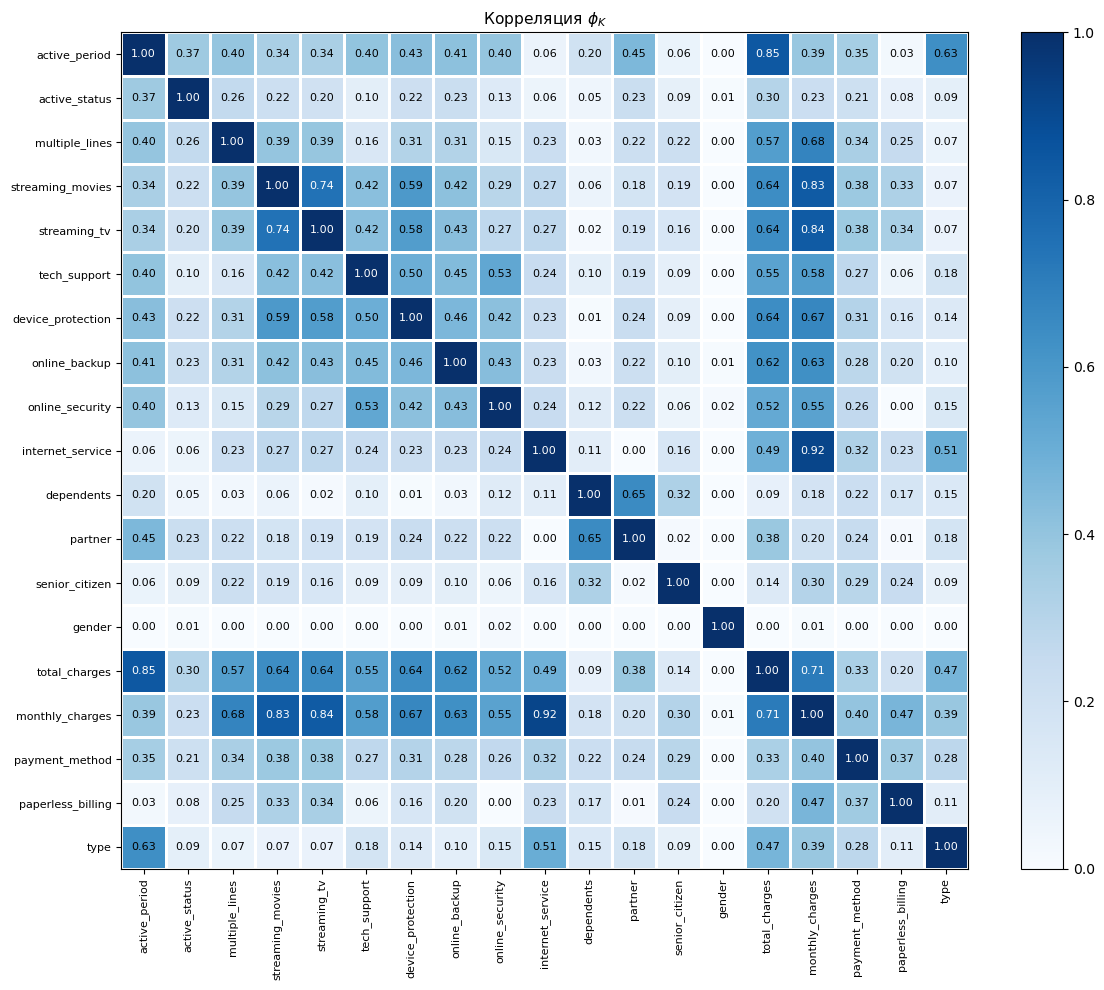

In [95]:
plot_correlation_matrix(phik_corr.values, 
                        x_labels=phik_corr.columns, 
                        y_labels=phik_corr.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

### 📌 Признаки с максимальной кореляцией с `activestatus`:

| Признак              | Корреляция | Комментарий |
|----------------------|------------|----------------|
| `active_period`      | **0.37**   | Чем дольше клиент с компанией, тем выше шанс быть активным |
| `total_charges`      | **0.30**   | Клиенты, потратившие больше денег, чаще остаются |
| `multiple_lines`     | **0.26**   | Наличие нескольких линий связано с активностью |
| `online_backup`      | **0.23**   | Клиенты с облачным хранилещем дольше активны |
| `monthlycharges`     | **0.23**   | Более дорогой тариф — чаще остаются (возможно, более лояльны) |

---

### 🧊 Признаки со слабой корреляцией:

| Признак             | Корреляция | Комментарий |
|---------------------|------------|-------------|
| `gender`            | 0.01       | Пол почти не влияет |
| `dependents`        | 0.05       | Наличие детей — слабая связь |
| `internetservice`   | 0.06       | Тип интернета почти не влияет |

---

## 🧾 Вывод

1. **Самый значимый фактор активности клиента** — это **длительность обслуживания (`active_period`)** и **суммарные траты (`total_charges`)**.
2. **Дополнительные услуги (`online_backup`, `multiple_lines` и т.п.)** — позитивно связаны с активностью. Их наличие удерживает клиентов.
3. **Высокие ежемесячные платежи (`monthlycharges`)** тоже немного повышают шанс активности — возможно, такие клиенты больше завязаны на сервисе.
4. **Социальные параметры** (пол, партнёр, дети) почти не влияют на активность.

---

In [96]:
def chart(index): 
    pivot_type = df_new.pivot_table(
        values='active_period', 
        columns='active_status', 
        index=index, 
        aggfunc='count'
    )
    pivot_type.columns = pivot_type.columns.astype(str)
    pivot_percent = pivot_type.copy().reset_index()
    cols = ['False', 'True']
    pivot_percent[cols] = pivot_percent[cols].div(pivot_percent[cols].sum(axis=1), axis=0) * 100
    pivot_percent.set_index(index)[cols].plot(kind='bar', stacked=True, figsize=(8, 5))
    plt.title(f'Процентное соотношение активных/неактивных по {index}')
    plt.ylabel('% клиентов')
    plt.xlabel(index)
    plt.legend(title='Active Status')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

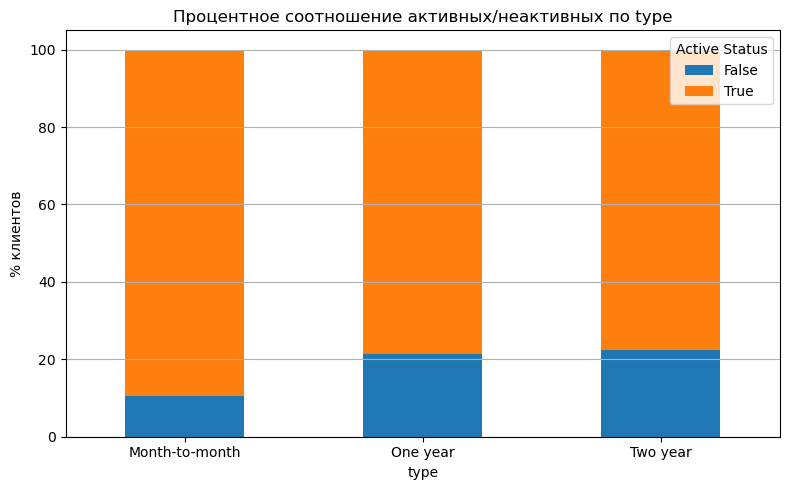

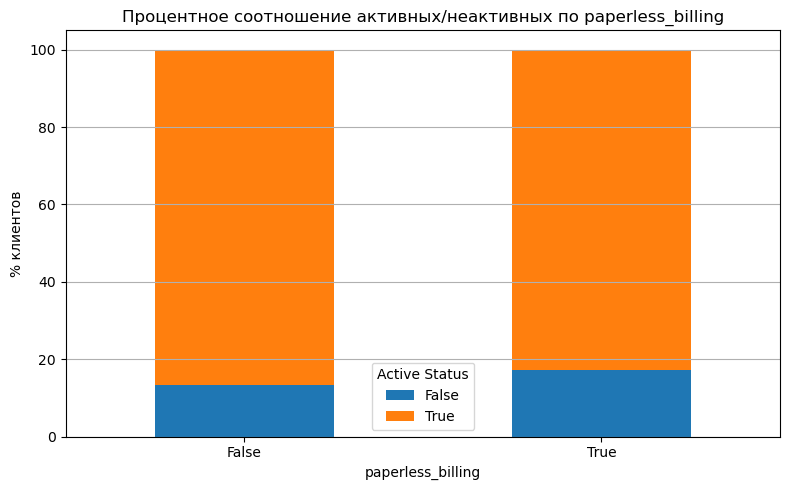

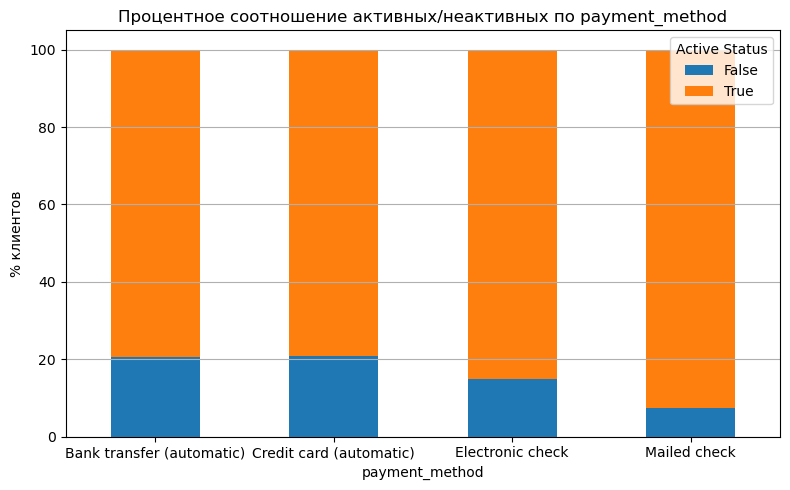

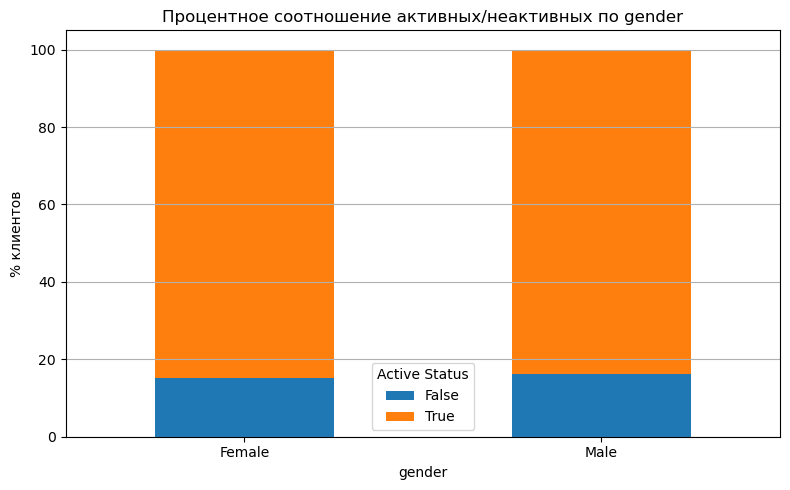

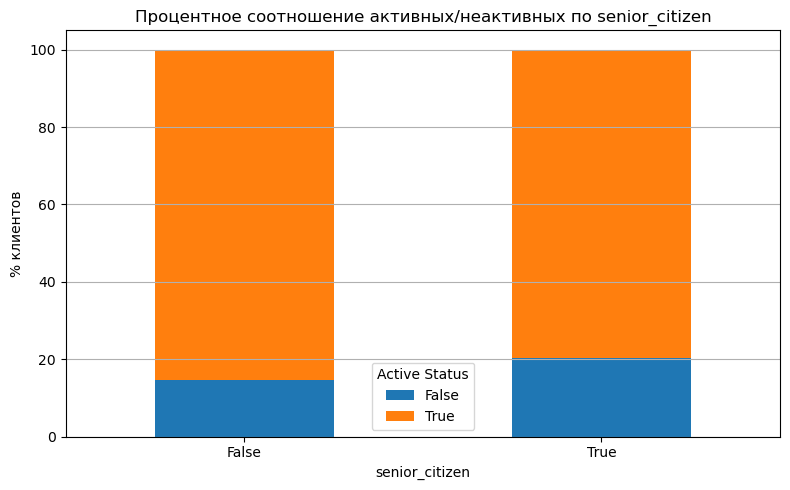

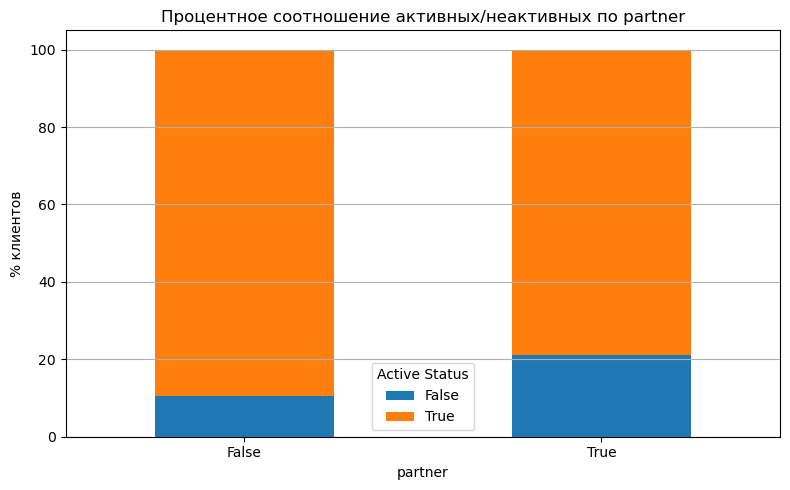

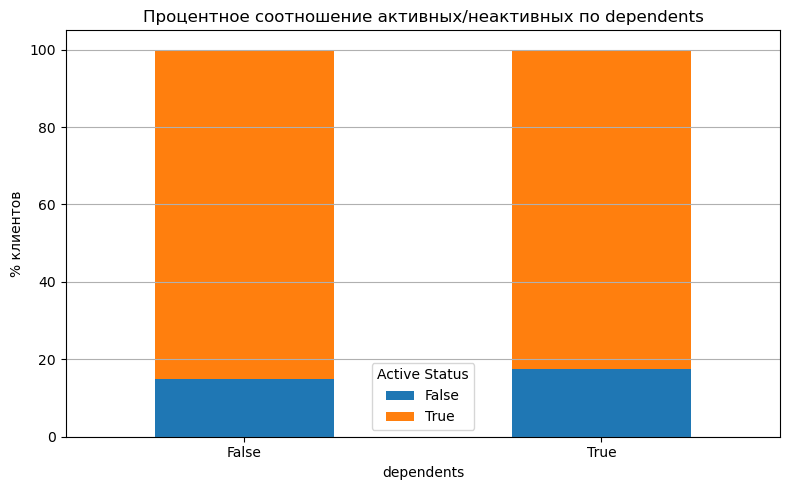

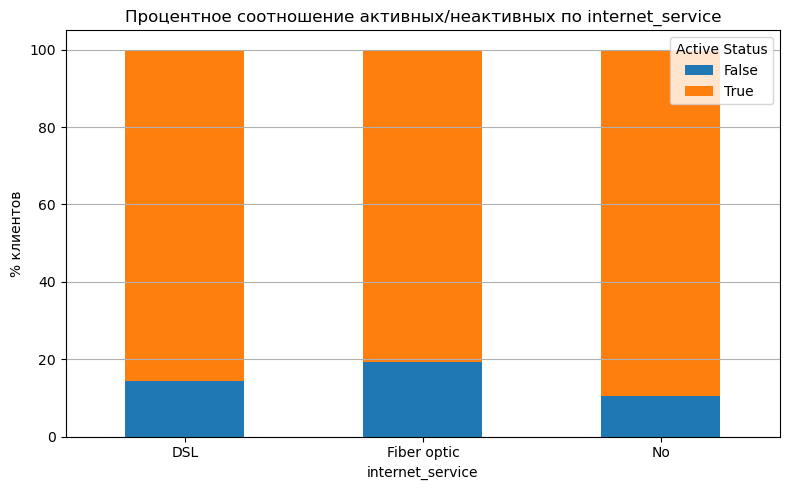

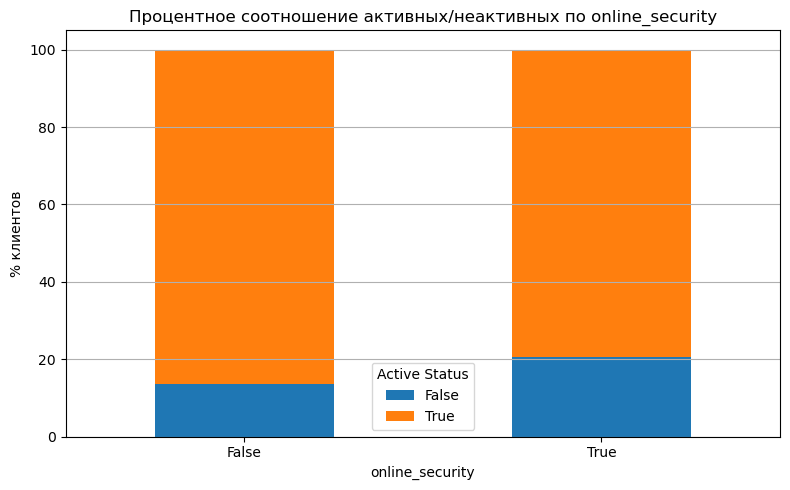

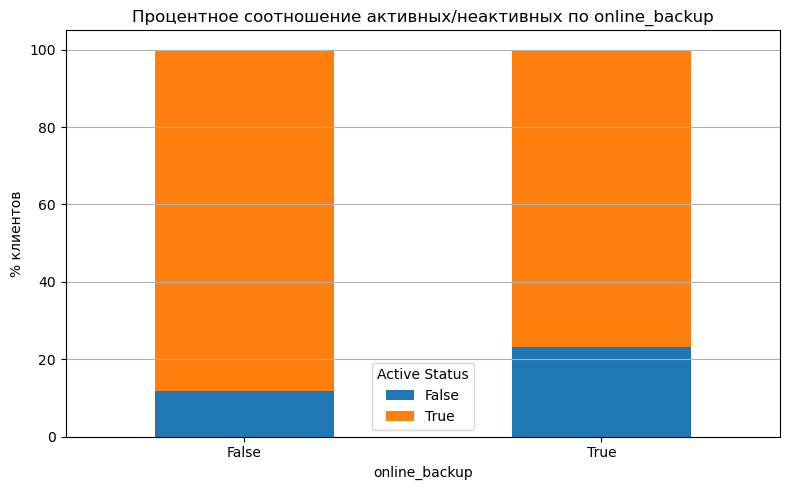

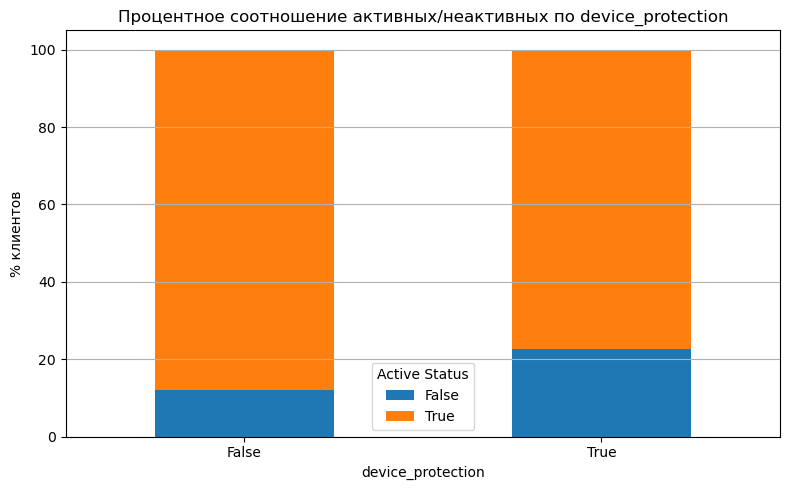

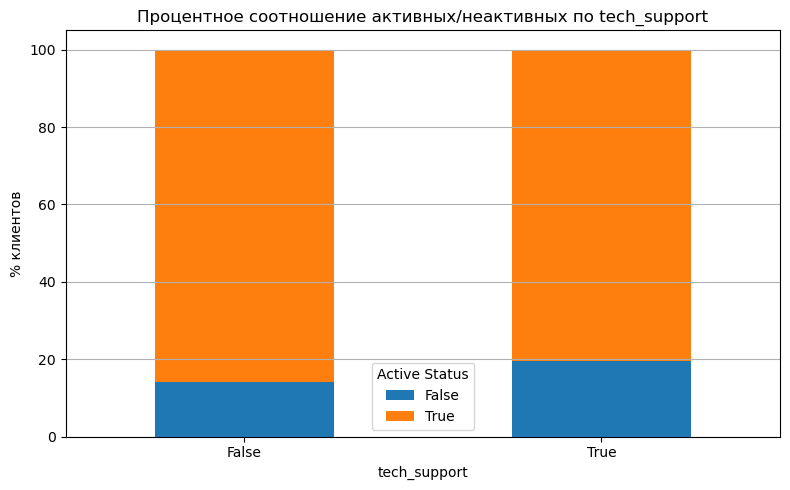

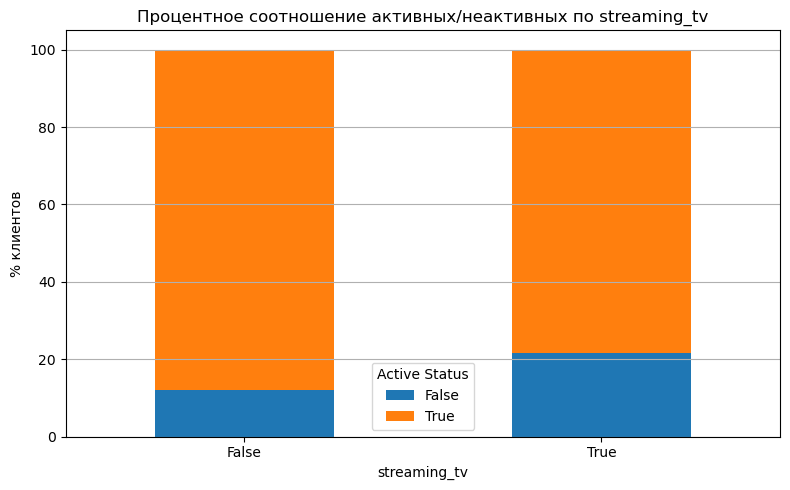

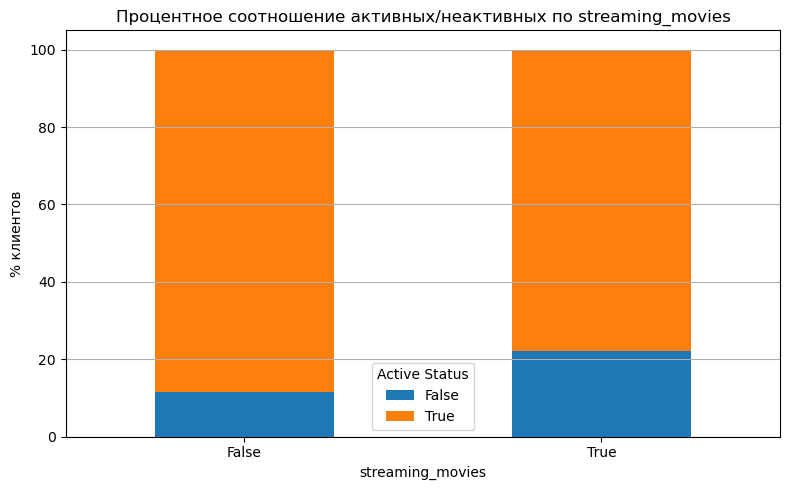

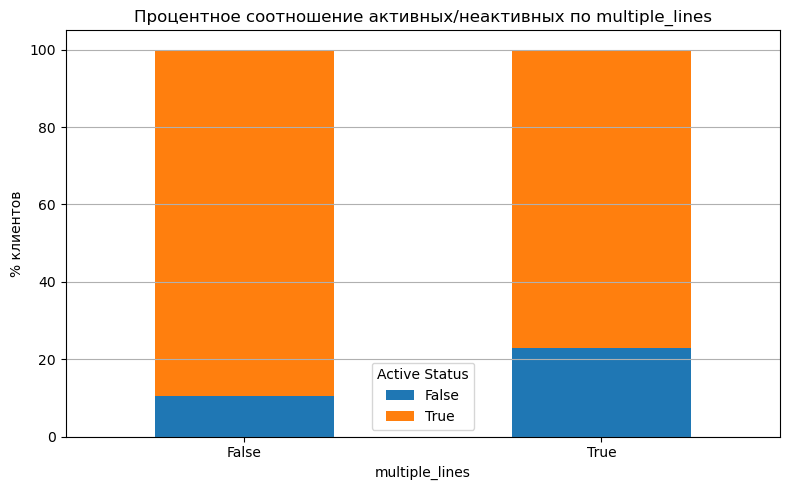

In [97]:
for col in df_new.columns:
    if col == 'active_status':
        continue  

    if df_new[col].dtype in ['object', 'bool'] and df_new[col].nunique() <= 10:
        try:
            chart(col)
        except Exception as e:
            print(f'Не удалось построить график для \"{col}\": {e}')

In [98]:
df_new['multiple_lines'].unique()

array([False, True], dtype=object)

## Вывод  
**Портрет клиента, склонного к расторжению договора:**

1. Выбирает оплату раз в 1–2 года  
2. Использует электронный счёт  
3. Предпочитает автоматическую оплату через банковский перевод или кредитную карту  
4. Пол не оказывает существенного влияния  
5. Является пенсионером  
6. Состоит в партнёрских отношениях  
7. Имеет детей на иждивении  
8. Подключён к оптоволоконному интернету  
9. Активно использует дополнительные услуги

## 4. Обучение модели

In [99]:
X = df_new.drop(columns=['active_status'], axis=1)
y = df_new['active_status'].astype(int)

In [100]:
num_col = ['monthly_charges', 
           'total_charges', 
           'active_period']         

In [101]:
ohe_col = ['type', 
           'payment_method', 
           'gender', 
           'internet_service']

In [102]:
ord_col = ['paperless_billing', 
           'senior_citizen', 
           'partner', 
           'dependents',
           'online_security', 
           'online_backup',
           'device_protection', 
           'tech_support', 
           'streaming_tv', 
           'streaming_movies',
           'multiple_lines']

In [103]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first'), ohe_col),
        ('num', StandardScaler(), num_col),
        ('ord', OrdinalEncoder(), ord_col)
    ])

In [104]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [105]:
param_grid = [{
    'classifier' : [RandomForestClassifier(random_state=42)],
    'classifier__n_estimators' : [200, 500],
    'classifier__max_depth' : [10, 50],
    'classifier__min_samples_split' : [5, 12],
    },
    {
    'classifier' : [LGBMClassifier(random_state=42)],
    'classifier__scale_pos_weight' :[5, 7, 10],
    'classifier__n_estimators' : [500, 1000, 1500],
    'classifier__max_depth' : [10, 20],
    'classifier__learning_rate' : [0.01, 0.1],
    'classifier__num_leaves' : [5, 6, 10]
    }
]

In [106]:
param_grid

[{'classifier': [RandomForestClassifier(random_state=42)],
  'classifier__n_estimators': [200, 500],
  'classifier__max_depth': [10, 50],
  'classifier__min_samples_split': [5, 12]},
 {'classifier': [LGBMClassifier(random_state=42)],
  'classifier__scale_pos_weight': [5, 7, 10],
  'classifier__n_estimators': [500, 1000, 1500],
  'classifier__max_depth': [10, 20],
  'classifier__learning_rate': [0.01, 0.1],
  'classifier__num_leaves': [5, 6, 10]}]

In [107]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5634, 18), (1409, 18), (5634,), (1409,))

In [109]:
start_grid_searh = time.time()
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 116 candidates, totalling 580 fits
[LightGBM] [Info] Number of positive: 4737, number of negative: 897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 731
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.840788 -> initscore=1.664103
[LightGBM] [Info] Start training from score 1.664103


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['type',
                                                                          'payment_method',
                                                                          'gender',
                                                                          'internet_service']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['monthly_charges',
                                                                          'total_charges',
                                                                          'active_period']),
                                                                        ('ord',
                                                                         OrdinalEncoder(),
                                                                         ['paperless_billing',
                                                                          'senior_citizen',
                                                                          'partner',
                                                                          'dependents',
                                                                          'onlin...
                          'classifier__max_depth': [10, 50],
                          'classifier__min_samples_split': [5, 12],
                          'classifier__n_estimators': [200, 500]},
                         {'classifier': [LGBMClassifier(random_state=42)],
                          'classifier__learning_rate': [0.01, 0.1],
                          'classifier__max_depth': [10, 20],
                          'classifier__n_estimators': [500, 1000, 1500],
                          'classifier__num_leaves': [5, 6, 10],
                          'classifier__scale_pos_weight': [5, 7, 10]}],
             scoring='roc_auc', verbose=2)

In [110]:
print('Лучшие параметры:', grid_search.best_params_ )

Лучшие параметры: {'classifier': LGBMClassifier(random_state=42), 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 1500, 'classifier__num_leaves': 5, 'classifier__scale_pos_weight': 5}


In [111]:
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [112]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.9319


In [117]:
y_pred = (y_pred_proba >= 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.93


## 💡 Рекомендации

- **Выделить клиентов с коротким `active_period` и небольшими `total_charges`** — они наиболее уязвимы к уходу.
- **Продвигать дополнительные сервисы (backup, protection, многолинейность)** для повышения лояльности.
- Использовать признаки `active_period`, `total_charges`, `multiple_lines`, `online_backup`, `monthly_charges` как ключевые при обучении модели прогнозирования оттока.